# 2025 Pocono Monte Carlo Simulation

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import requests
from PIL import Image
from io import BytesIO
from collections import Counter

In [15]:
cup_roster = pd.read_csv("https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/refs/heads/main/Master-Data/2025-cup-series-full-timers.txt")

In [16]:
simulation_data = pd.read_csv("https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/main/Pocono-Driver-Data/pocono-sim-ready-data.csv")
simulation_data.head()

,Unnamed: 0,Driver,Avg Finish,Wins,Top 5's,DNF,Avg Rating,szn_Avg Finish,szn_Wins,szn_Top 5's,szn_Avg Rating,DNF_Prob,track_Laps Led Per Race,szn_Laps Led Per Race,Std Dev
0,0,William Byron,9.4,0,3,0,96.7,10.4,1,7,106.7,0.030000,11.818182,48.062500,2.5
1,1,Brad Keselowski,10.8,1,11,1,94.4,24.3,0,1,62.9,0.037037,9.148148,0.500000,2.5
2,2,Denny Hamlin,11.3,7,16,3,108.7,13.5,3,7,94.3,0.085714,24.514286,30.333333,2.5
3,3,Kyle Larson,11.6,0,5,0,95.8,12.8,3,9,96.0,0.030000,9.294118,53.187500,2.5
4,4,Ryan Blaney,13.4,2,3,1,89.6,17.4,1,6,90.6,0.066667,6.333333,21.625000,3.5


In [17]:
def simulate_race(df):
    finish_positions = []
    
    for _, row in df.iterrows():
        # calculate a performance bonus to add a weight to drivers who have performed well
        # at track in categories other than avg. finish
        performance_bonus = (
            0.40 * row['Wins'] +                         # wins @ track
            0.20 * row['szn_Wins'] +                     # season wins
            0.10 * row['track_Laps Led Per Race'] +      # laps led per race @ track
            0.10 * row['szn_Laps Led Per Race'] +        # laps led per race over szn
            0.05 * row['Avg Rating'] +                   # average rating on the track
            0.05 * row['szn_Avg Rating'] +                # average rating over whole season
            0.05 * row['Top 5\'s'] +                     # top 5's @ track 
            0.05 * row['szn_Top 5\'s']                   # season top 5's
        )

        # Apply bonus: decrease average finish (but not below 1)
        adjusted_avg_finish = max(1, (row['Avg Finish'] + (0.5 * row['szn_Avg Finish']))/2 - performance_bonus * 0.25)

        # quick check for a DNF
        dnf = np.random.rand() < row['DNF_Prob']
        
        if dnf:
            # DNF finish at the back of the pack
            finish_pos = np.random.randint(len(df) + 1, len(df) + 6)
        else:
            # Finished race: sample finish from a normal distribution centered at the
            # adjusted average finish location we found earlier (help incorporate things like wins)
            # use the std dev calculated from avg finish to control variability
            finish_pos = np.random.normal(loc=adjusted_avg_finish, scale=row['Std Dev'])
            
            # bound finish position between 1 and number of drivers so we get nothing crazy
            finish_pos = max(1, min(len(df), finish_pos))
        
        finish_positions.append((row['Driver'], finish_pos, dnf))
    
    # convert the list to a dataframe to sort and view easier
    results = pd.DataFrame(finish_positions, columns=['Driver', 'Finish_Pos', 'DNF'])
    
    # sort by DNF first (non-DNF comes first), then finish position
    results = results.sort_values(by=['DNF', 'Finish_Pos'], ascending=[True, True]).reset_index(drop=True)
    
    # driver in position 0 is the winner of that simulation
    winner = results.iloc[0]['Driver']
    return winner

def run_simulations(df, num_simulations=10000):
    win_counts = {driver: 0 for driver in df['Driver']}
    
    for i in range(num_simulations):
        winner = simulate_race(df)
        win_counts[winner] += 1
    
    # convert the list to a dataframe to sort and view easier
    win_probs = pd.DataFrame(list(win_counts.items()), columns=['Driver', 'Wins'])
    win_probs['Win_Prob'] = win_probs['Wins'] / num_simulations
    win_probs = win_probs.sort_values(by='Win_Prob', ascending=False).reset_index(drop=True)
    return win_probs

In [18]:
# run the simulation
results = run_simulations(simulation_data)
print(results)

                  Driver  Wins  Win_Prob
0          William Byron  3737    0.3737
1           Denny Hamlin  1992    0.1992
2            Kyle Larson  1333    0.1333
3          Chase Elliott   676    0.0676
4            Ryan Blaney   439    0.0439
5          Tyler Reddick   365    0.0365
6       Christopher Bell   337    0.0337
7             Erik Jones   154    0.0154
8            Joey Logano   128    0.0128
9         Chris Buescher   128    0.0128
10            Kyle Busch   123    0.0123
11         Bubba Wallace    95    0.0095
12         Chase Briscoe    84    0.0084
13            Josh Berry    68    0.0068
14         Austin Dillon    60    0.0060
15           Alex Bowman    51    0.0051
16              Ty Gibbs    45    0.0045
17       Brad Keselowski    41    0.0041
18         Daniel Suarez    31    0.0031
19     A.J. Allmendinger    25    0.0025
20        Austin Cindric    17    0.0017
21        Carson Hocevar    11    0.0011
22           Ryan Preece    11    0.0011
23  John Hunter 

C:\Users\jakel\AppData\Local\Temp\ipykernel_4616\1306530603.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x='Win_Prob', y='Driver', palette='viridis')


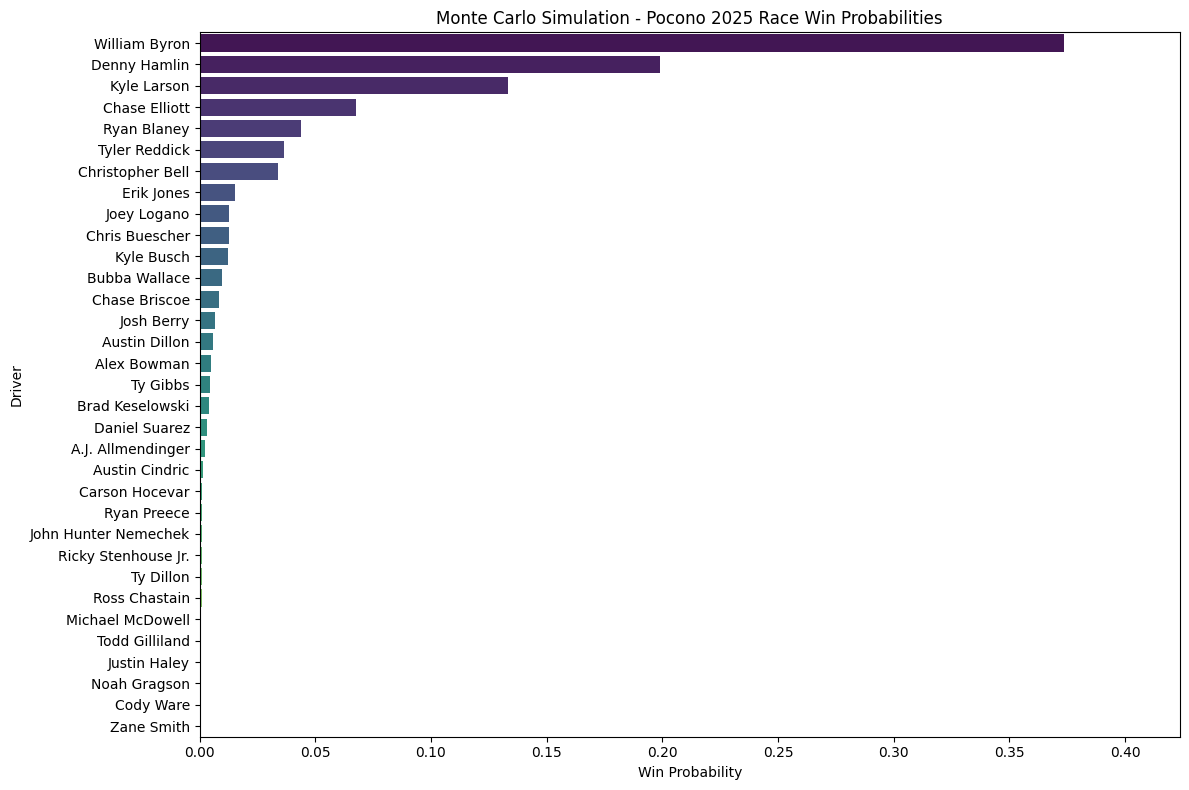

In [19]:
plt.figure(figsize=(12, 8))
sns.barplot(data=results, x='Win_Prob', y='Driver', palette='viridis')

plt.xlabel('Win Probability')
plt.ylabel('Driver')
plt.title('Monte Carlo Simulation - Pocono 2025 Race Win Probabilities')
plt.xlim(0, results['Win_Prob'].max() + 0.05)

plt.tight_layout()
plt.show()

In [20]:
results_with_nums = results.merge(cup_roster[['Driver', 'Car No.']], on='Driver', how='left')
top_10 = results_with_nums.sort_values(by='Win_Prob', ascending=False).head(10).reset_index(drop=True)
top_10

,Driver,Wins,Win_Prob,Car No.
0,William Byron,3737,0.3737,24
1,Denny Hamlin,1992,0.1992,11
2,Kyle Larson,1333,0.1333,5
3,Chase Elliott,676,0.0676,9
4,Ryan Blaney,439,0.0439,12
5,Tyler Reddick,365,0.0365,45
6,Christopher Bell,337,0.0337,20
7,Erik Jones,154,0.0154,43
8,Joey Logano,128,0.0128,22
9,Chris Buescher,128,0.0128,17


In [21]:
# really cool function to extract most common color from a png: you'll see it below
def get_main_hex_color(url):
    resp = requests.get(url)
    img = Image.open(BytesIO(resp.content)).convert('RGBA')
    img = img.resize((50, 50))  # resize to reduce TC
    pixels = list(img.getdata())

    # Filter out fully transparent pixels
    opaque_pixels = [pixel[:3] for pixel in pixels if pixel[3] != 0]
    if not opaque_pixels:
        return None

    color_counts = Counter(opaque_pixels).most_common()

    def is_black_or_white(rgb):
        return rgb == (0, 0, 0) or rgb == (255, 255, 255)

    # Find first most common color that is not black or white
    for color, count in color_counts:
        if not is_black_or_white(color):
            most_common_color = color
            break
    else:
        # fallback if all are black or white
        most_common_color = color_counts[0][0]

    return '#{:02x}{:02x}{:02x}'.format(*most_common_color)

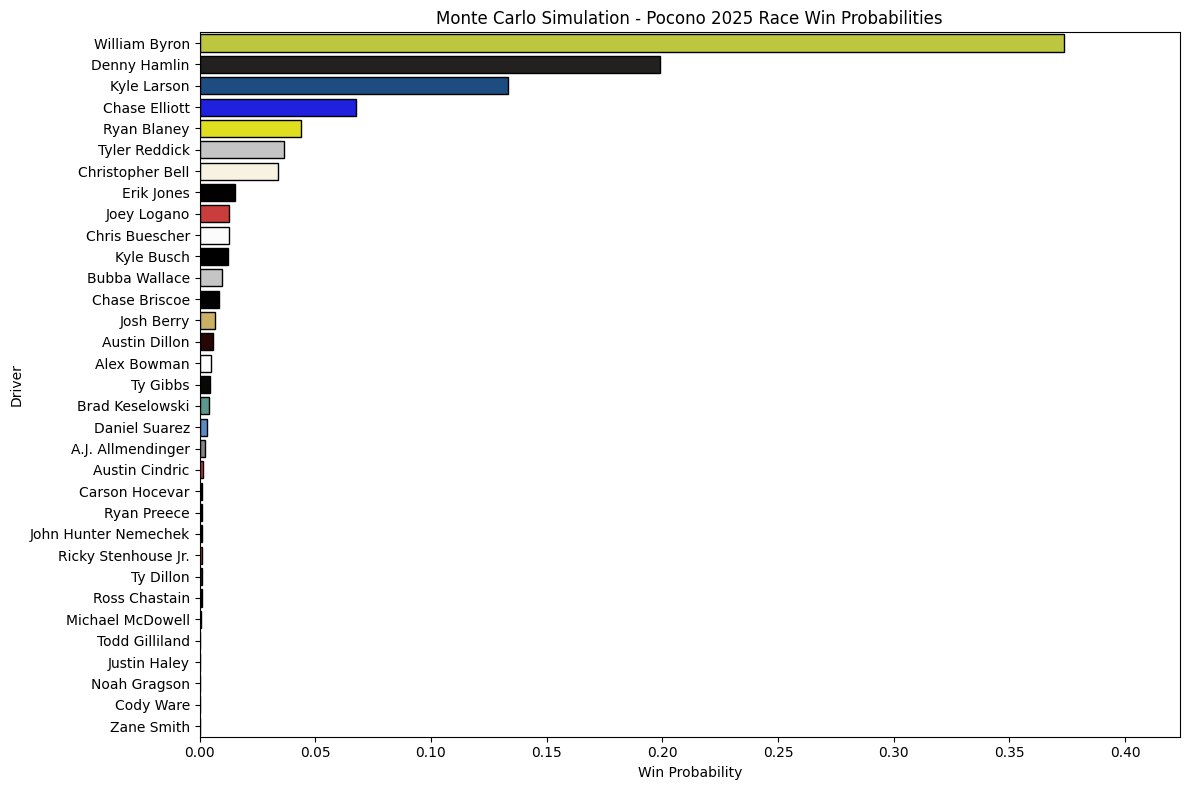

In [24]:
bar_colors = []

for idx, row in results.iterrows():
    car_num = cup_roster.loc[cup_roster['Driver'] == row['Driver'], 'Car No.'].values[0]
    img_url = f"https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/main/Driver-Num-Logos/{car_num}.png"
    col = get_main_hex_color(img_url)
    bar_colors.append(col)

plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=results,
    x='Win_Prob',
    y='Driver',
    hue='Driver',
    palette=bar_colors,
    dodge=False,
    legend=False
) # bunch of extra commands to dodge FutureWarning

for bar in barplot.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)
    
plt.xlabel('Win Probability')
plt.ylabel('Driver')
plt.title('Monte Carlo Simulation - Pocono 2025 Race Win Probabilities')
plt.xlim(0, results['Win_Prob'].max() + 0.05)

plt.tight_layout()
plt.show()

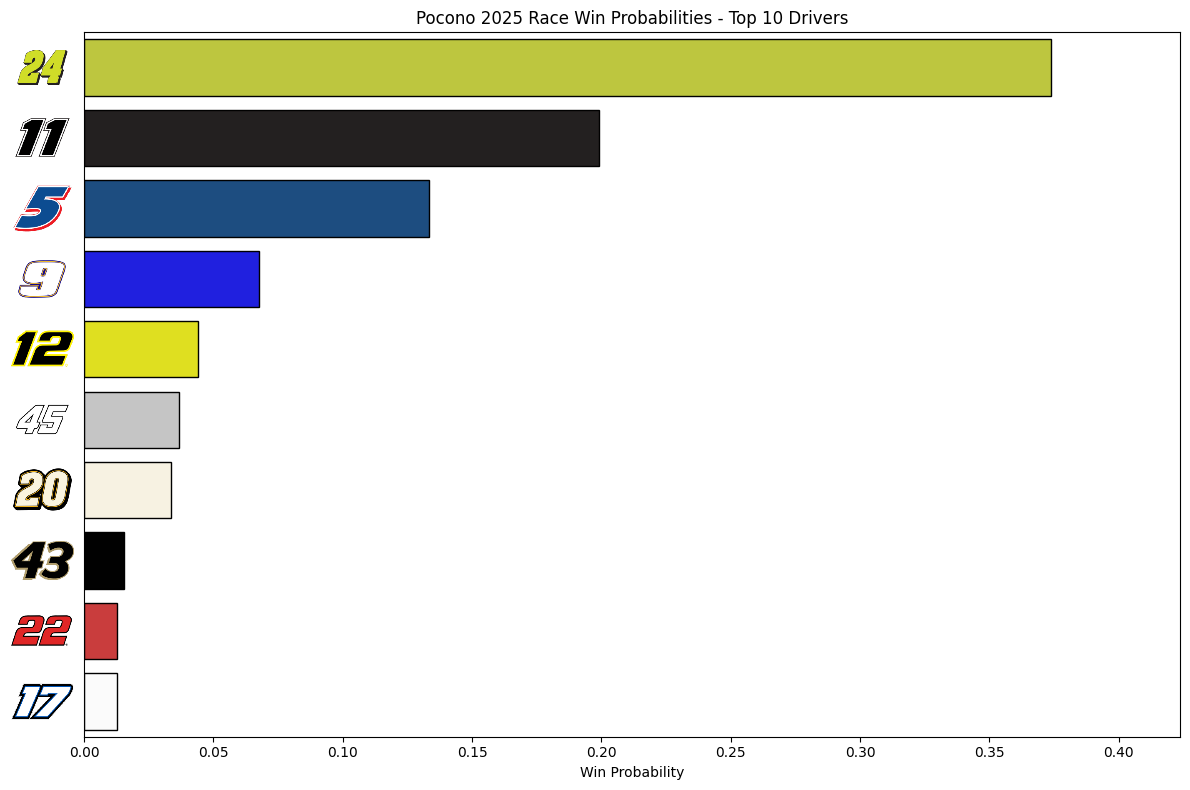

In [25]:
# define colors from driver num logo using function above 
bar_colors = []

for idx, row in top_10.iterrows():
    img_url = f"https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/main/Driver-Num-Logos/{row['Car No.']}.png"
    col = get_main_hex_color(img_url)
    bar_colors.append(col)

plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=top_10,
    x='Win_Prob',
    y='Driver',
    hue='Driver',
    palette=bar_colors,
    dodge=False,
    legend=False
) # bunch of extra commands to dodge FutureWarning

# add black outline
for bar in barplot.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(1)

plt.yticks([])

plt.xlabel('Win Probability')
plt.ylabel('')
plt.title('Pocono 2025 Race Win Probabilities - Top 10 Drivers')
plt.xlim(0, top_10['Win_Prob'].max() + 0.05)

# Add car number images
for i, car_num in enumerate(top_10['Car No.']):
    #Old logic when images were local; swapped out b/c GitHub storage
    #img_path = f"https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/main/Driver-Num-Logos/{car_num}.png"
    #image = plt.imread(img_path)
    response = requests.get(f"https://raw.githubusercontent.com/jake-lukasik/NASCAR-Race-Predictions/main/Driver-Num-Logos/{car_num}.png")
    image = Image.open(BytesIO(response.content))
    im = OffsetImage(image, zoom=0.3)
    ab = AnnotationBbox(im, (0, i), xybox=(-30, 0), frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)
    plt.gca().add_artist(ab)

plt.tight_layout()
plt.show()